100%|██████████| 188/188 [00:00<00:00, 48563.72it/s]


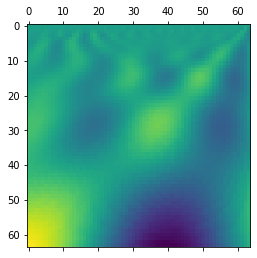

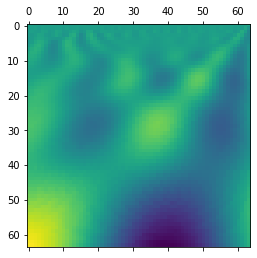

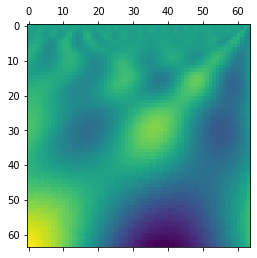

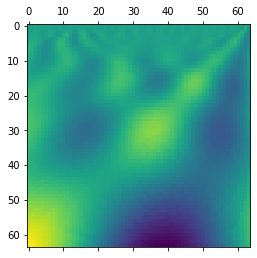

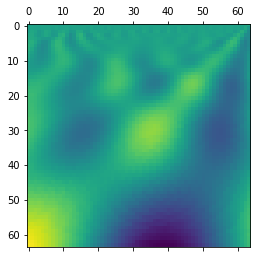

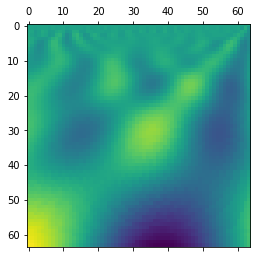

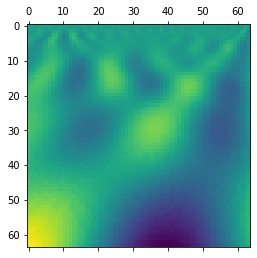

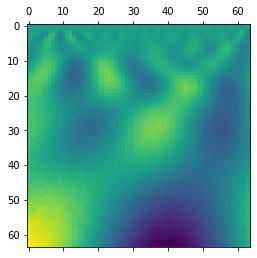

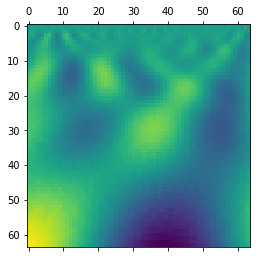

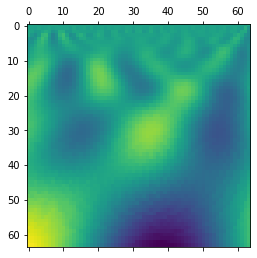

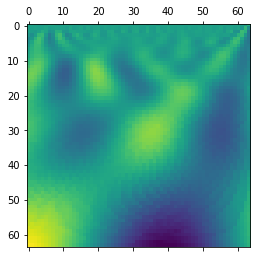

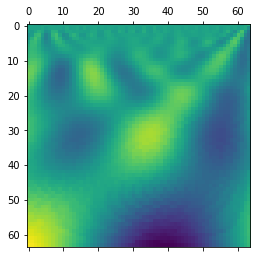

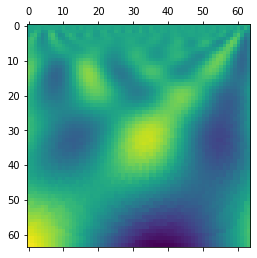

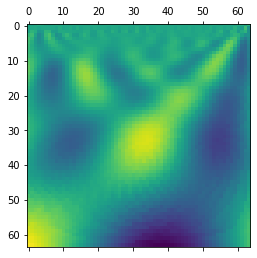

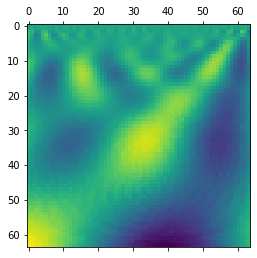

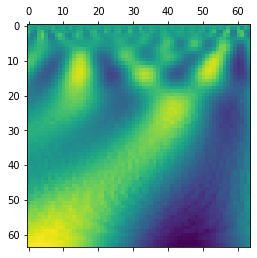

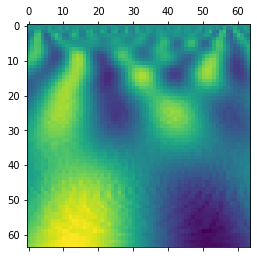

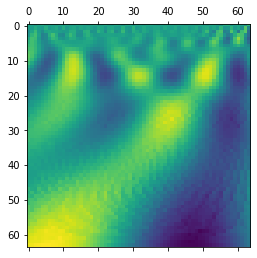

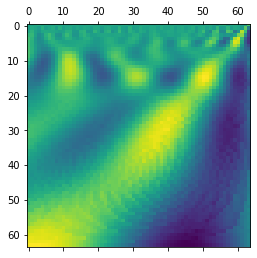

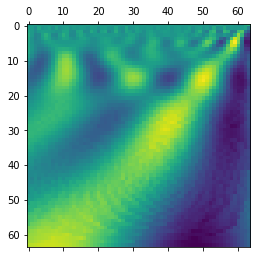

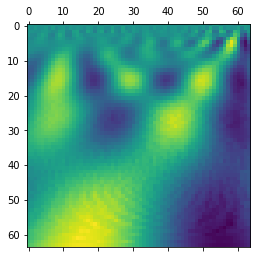

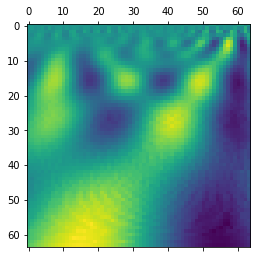

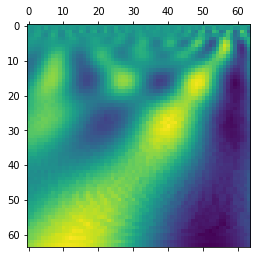

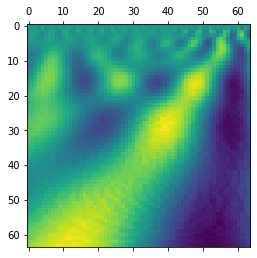

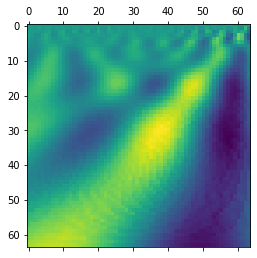

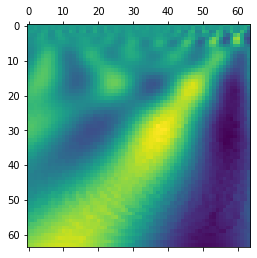

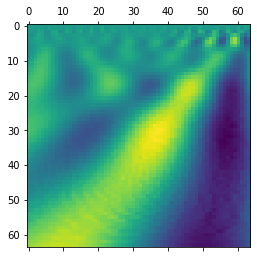

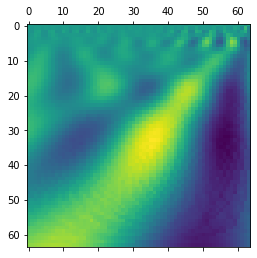

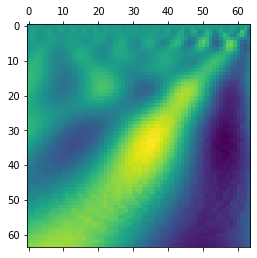

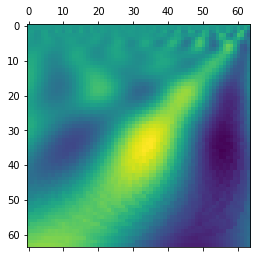

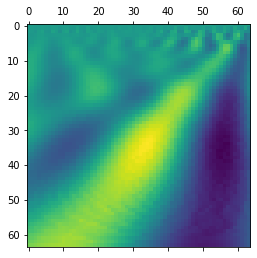

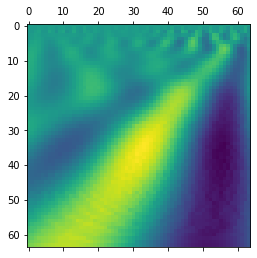

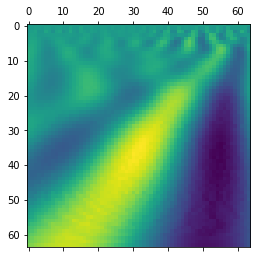

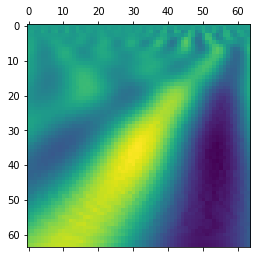

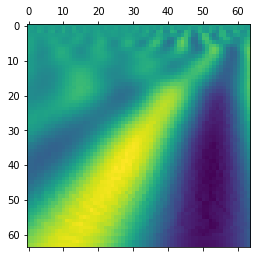

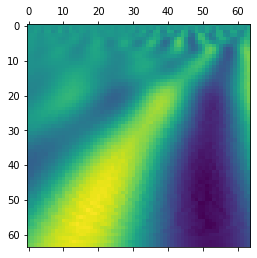

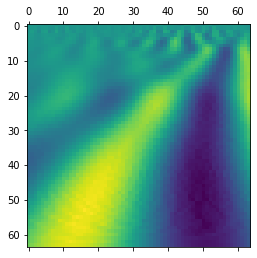

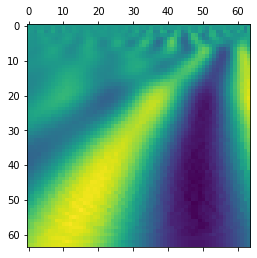

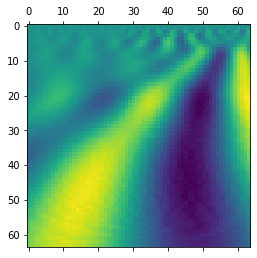

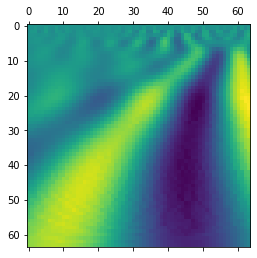

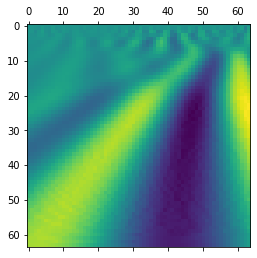

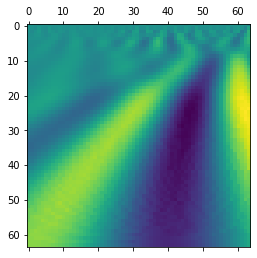

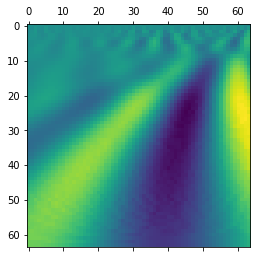

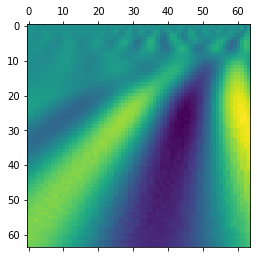

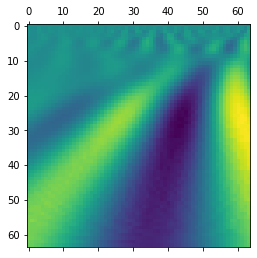

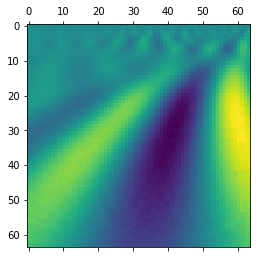

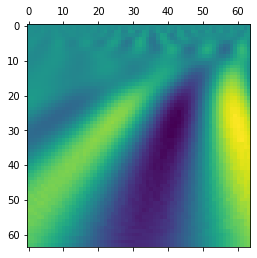

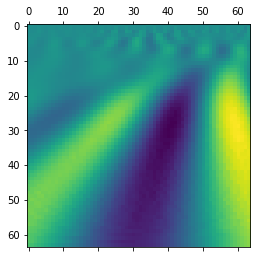

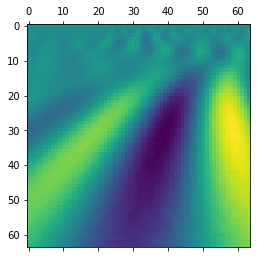

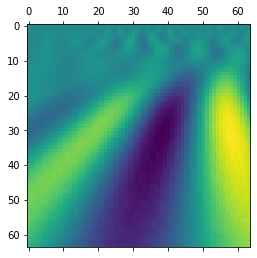

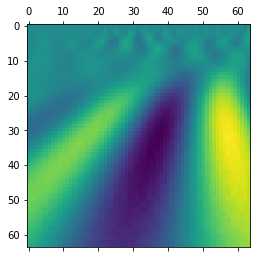

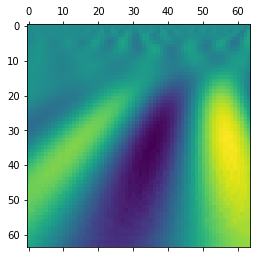

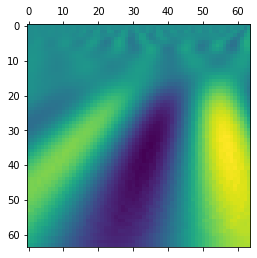

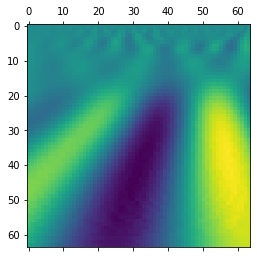

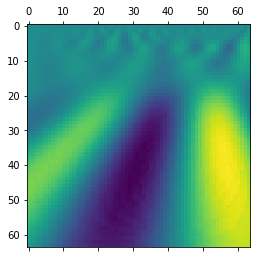

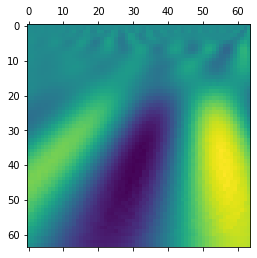

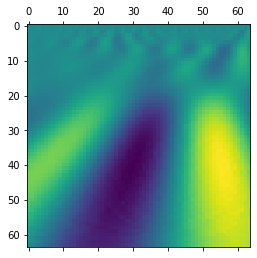

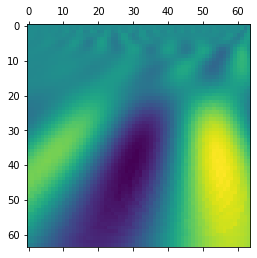

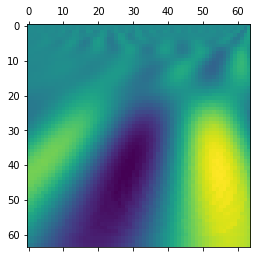

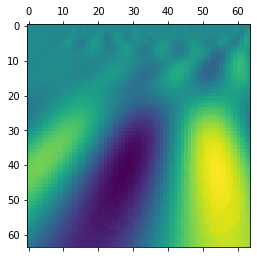

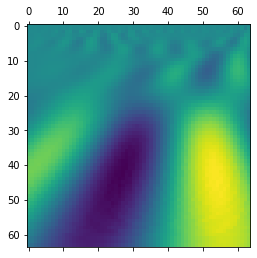

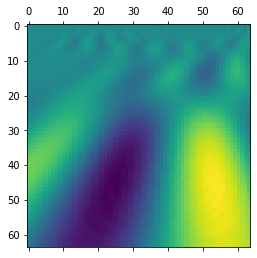

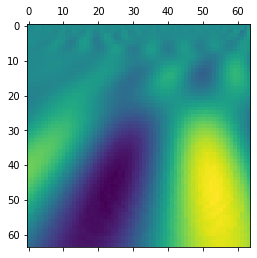

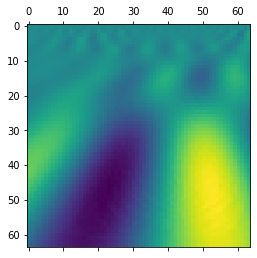

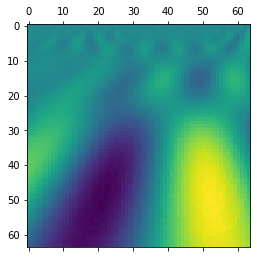

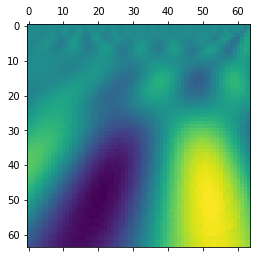

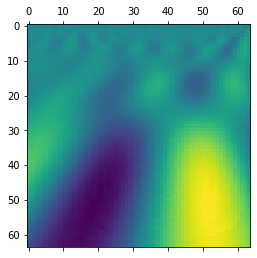

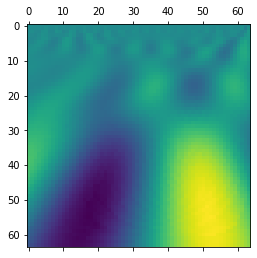

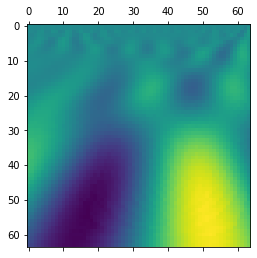

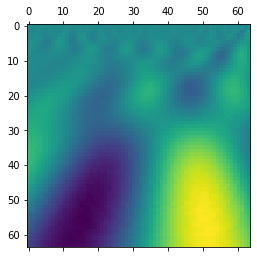

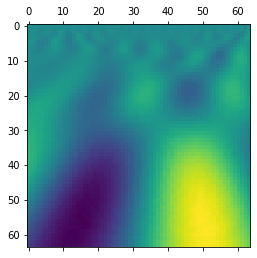

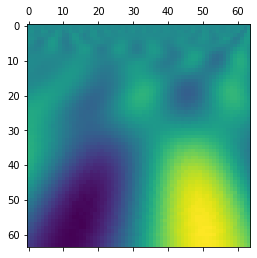

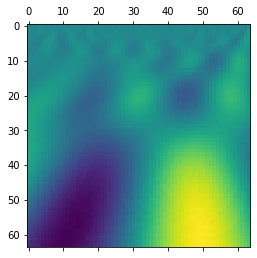

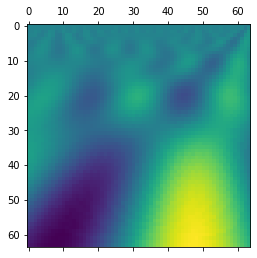

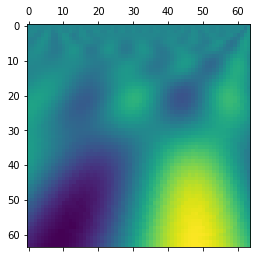

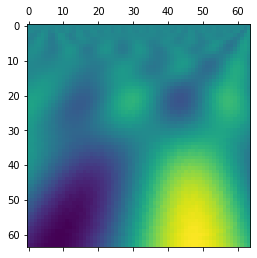

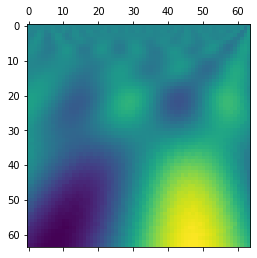

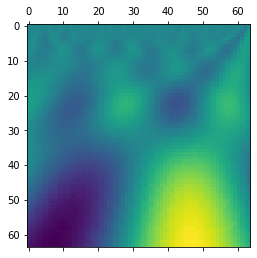

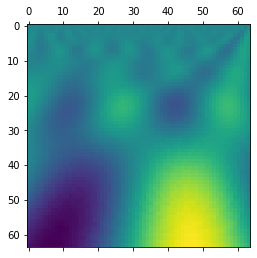

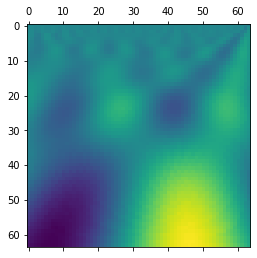

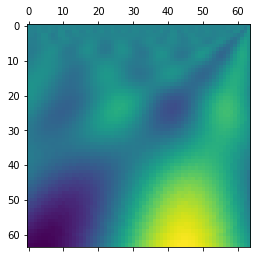

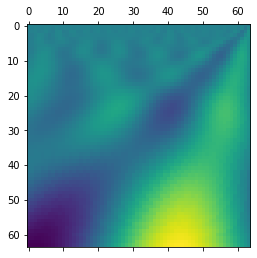

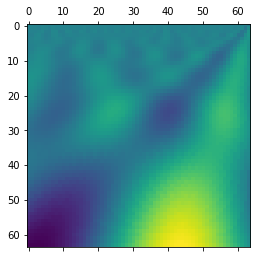

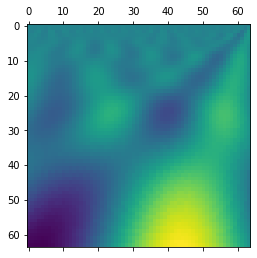

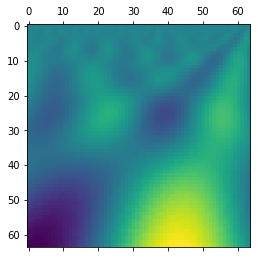

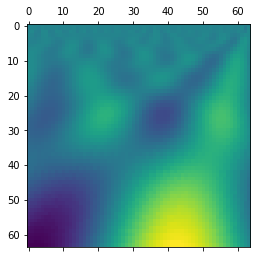

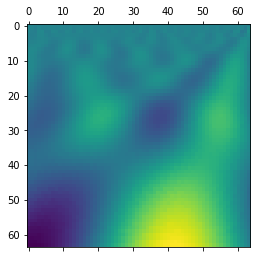

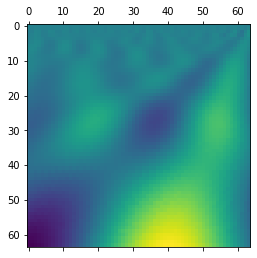

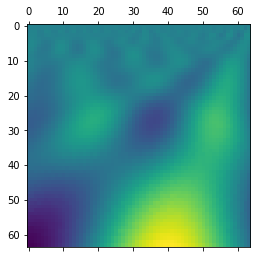

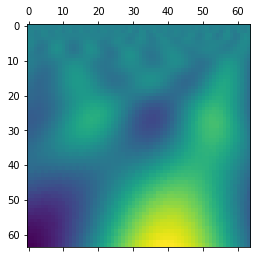

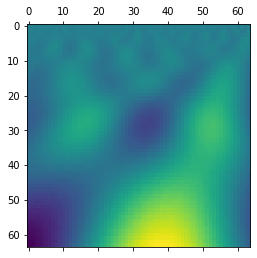

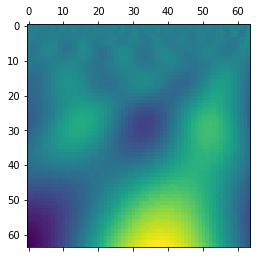

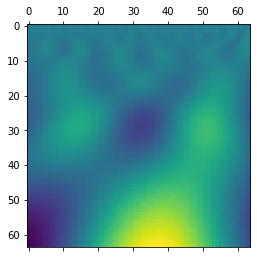

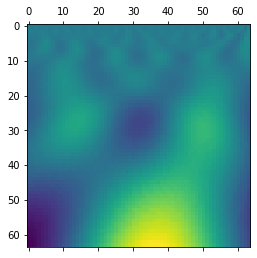

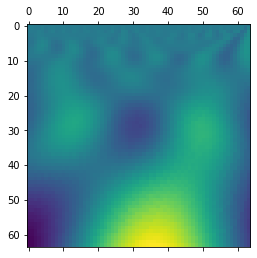

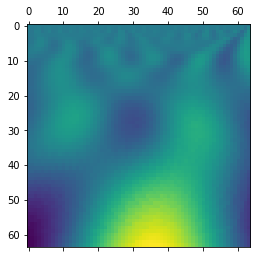

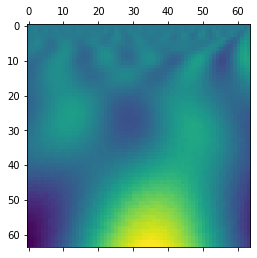

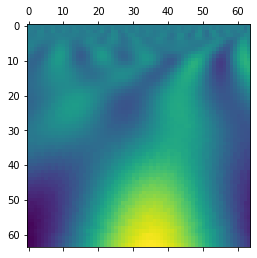

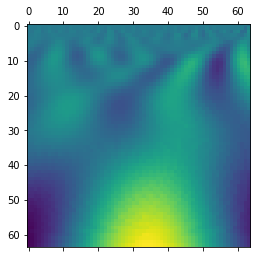

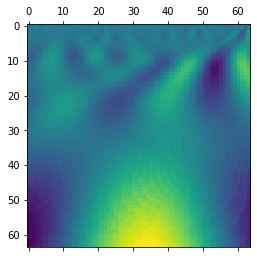

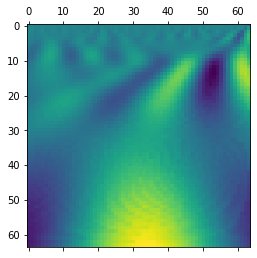

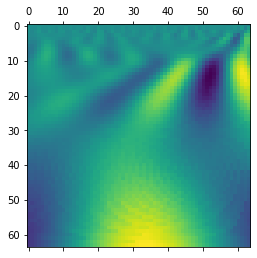

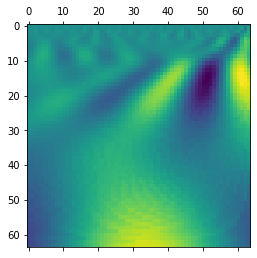

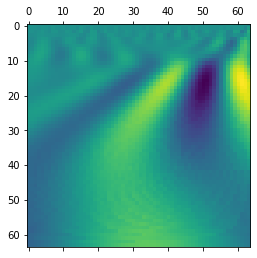

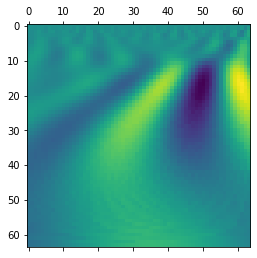

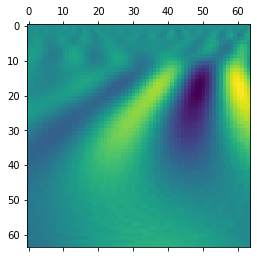

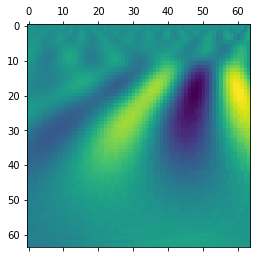

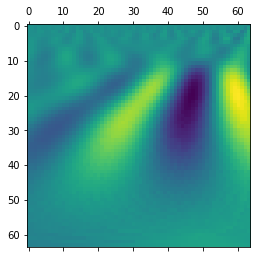

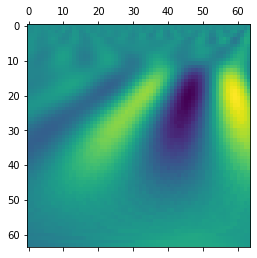

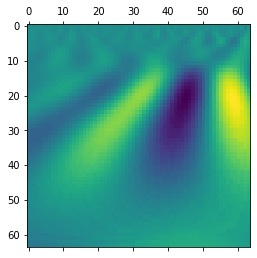

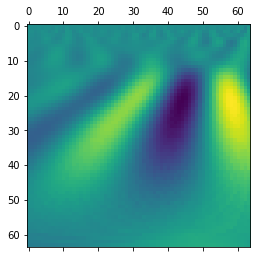

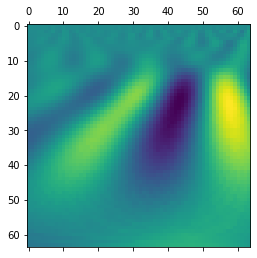

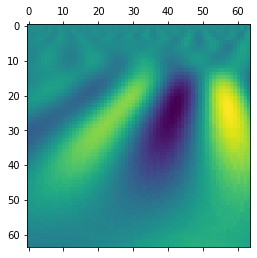

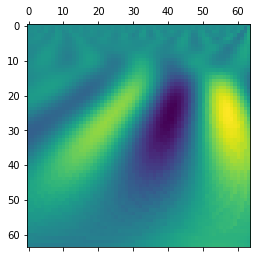

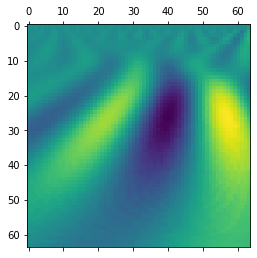

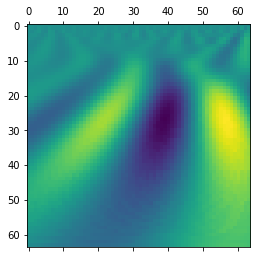

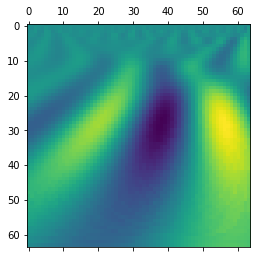

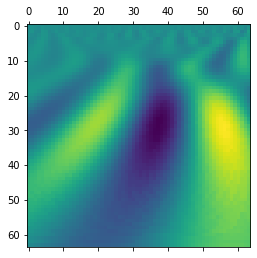

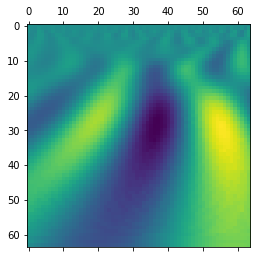

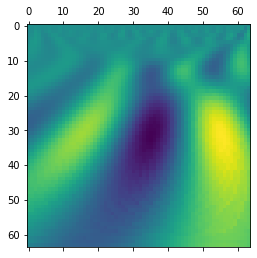

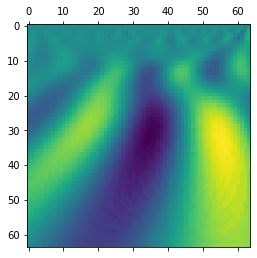

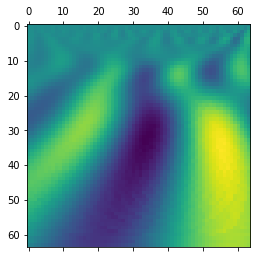

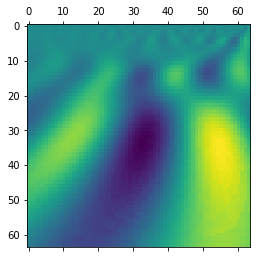

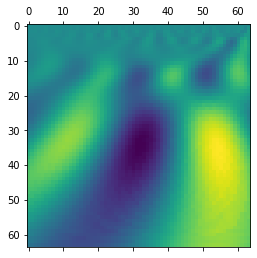

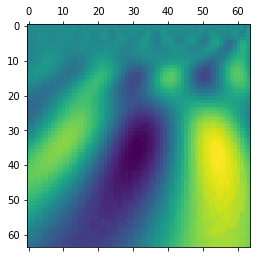

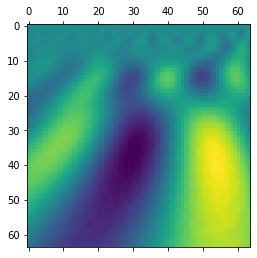

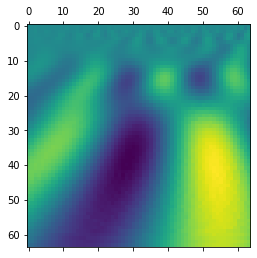

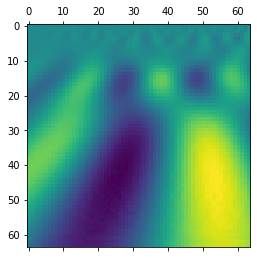

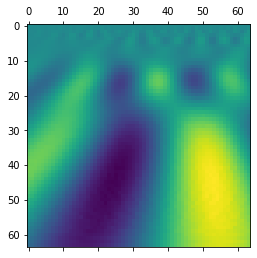

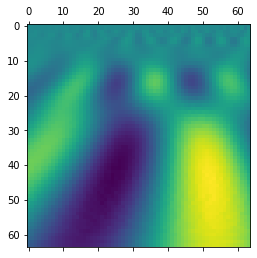

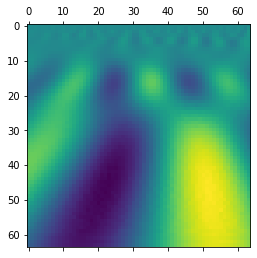

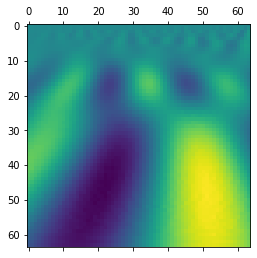

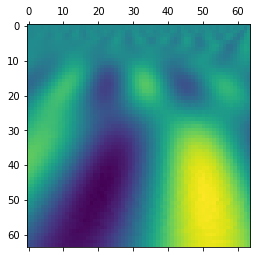

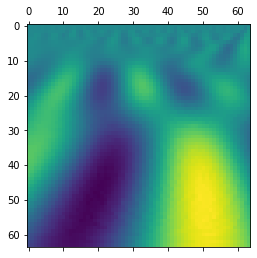

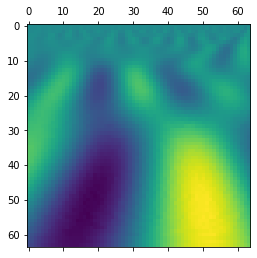

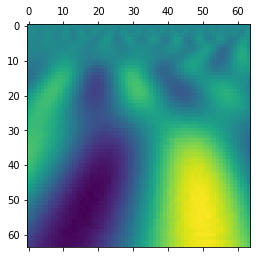

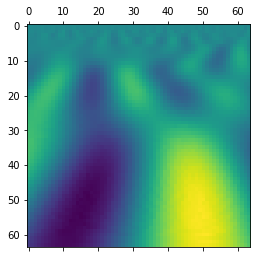

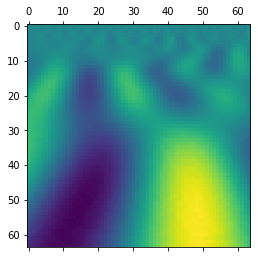

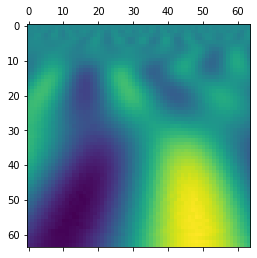

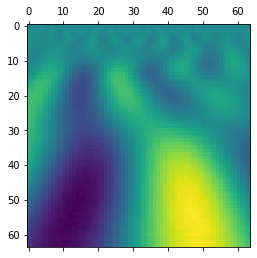

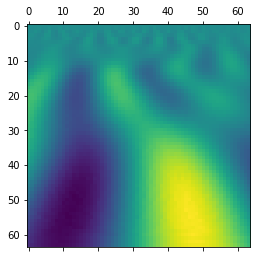

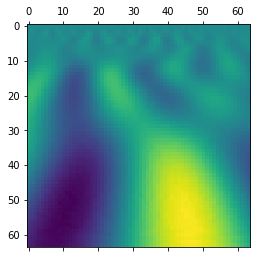

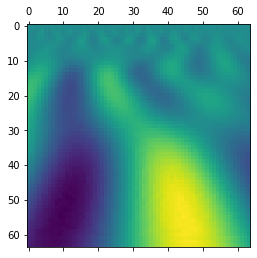

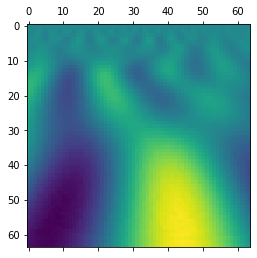

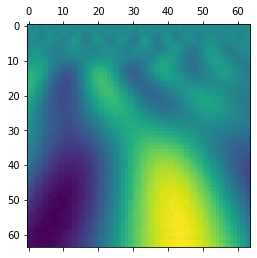

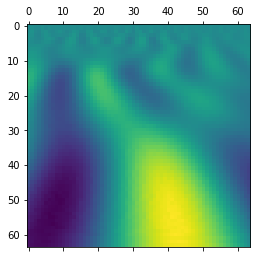

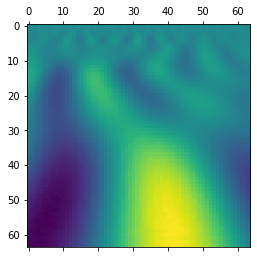

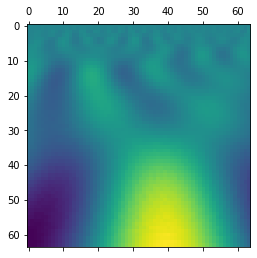

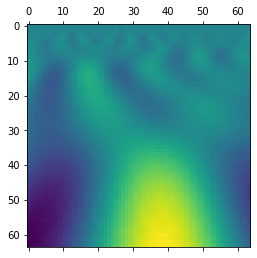

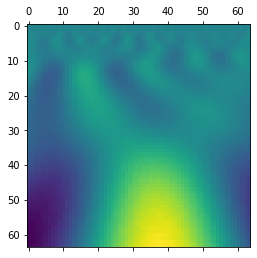

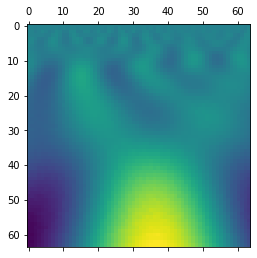

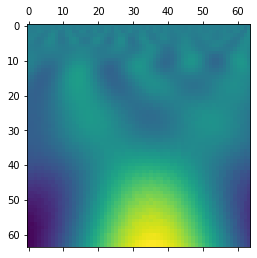

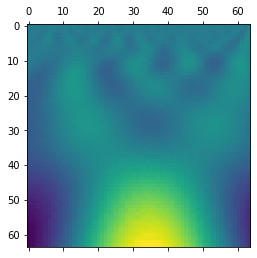

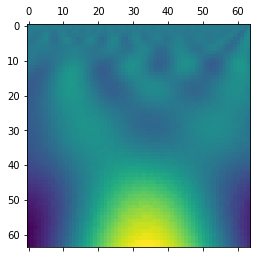

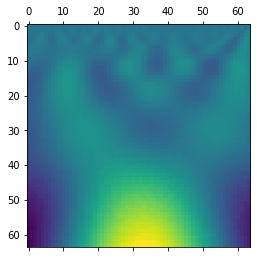

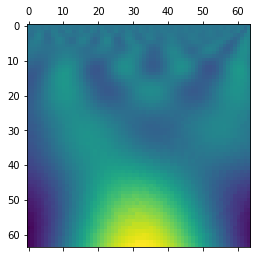

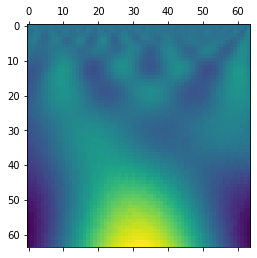

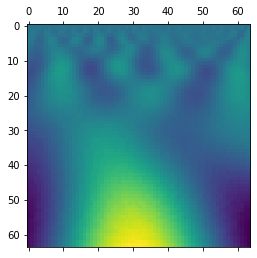

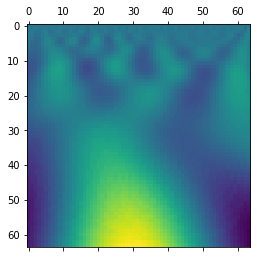

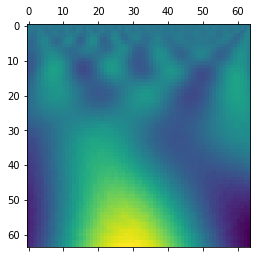

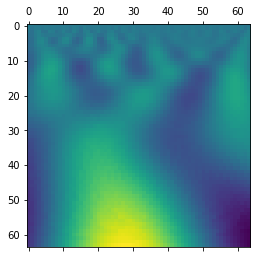

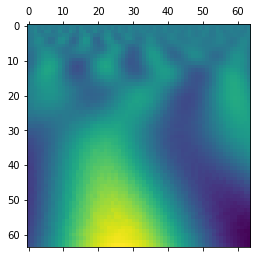

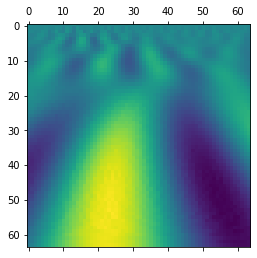

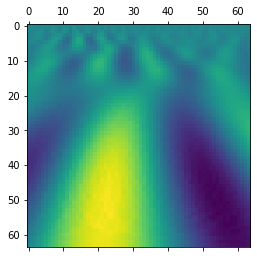

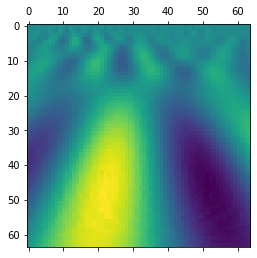

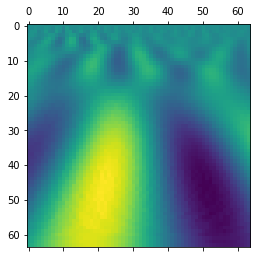

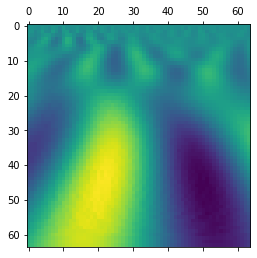

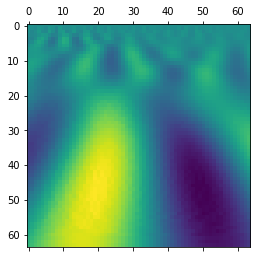

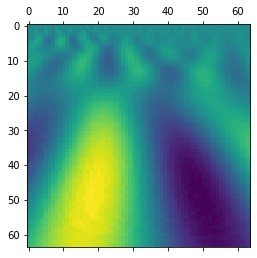

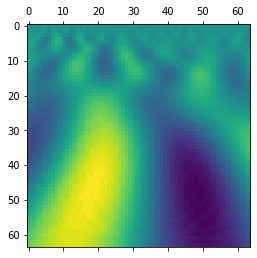

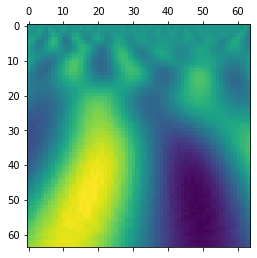

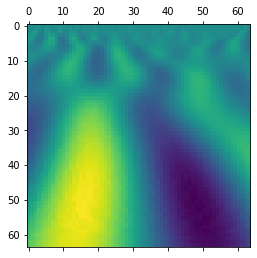

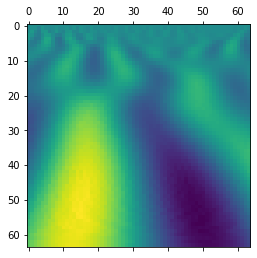

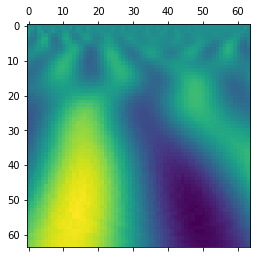

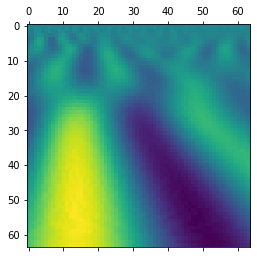

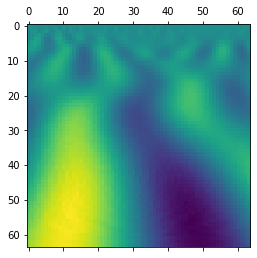

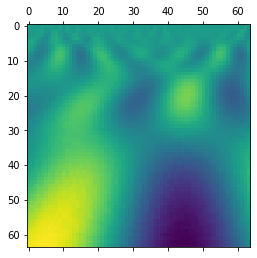

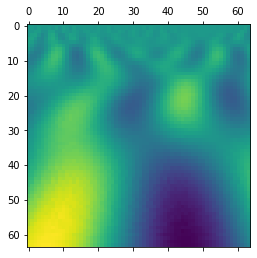

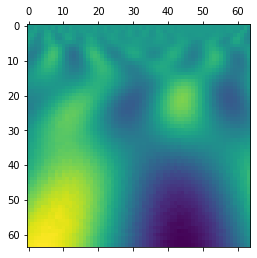

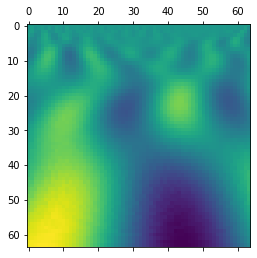

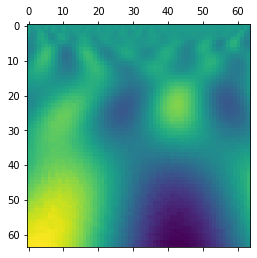

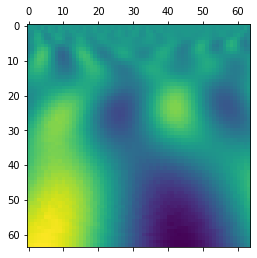

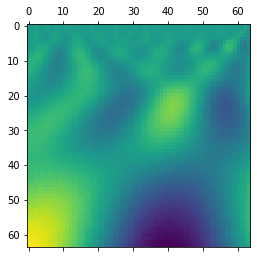

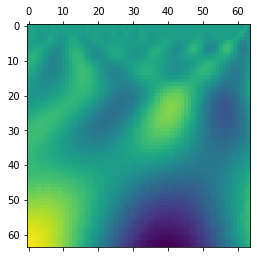

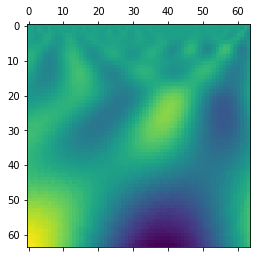

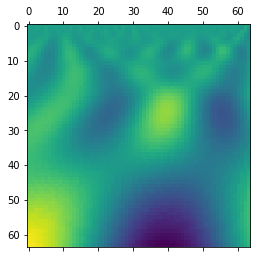

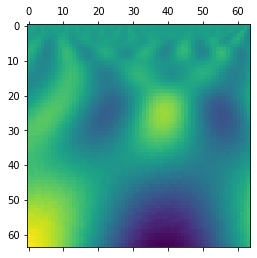

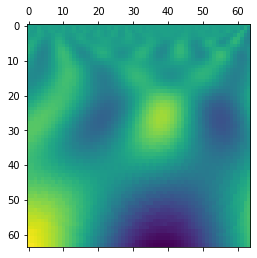

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

def roll(a, size, dx=1):
    shape = a.shape[:-1] + (int((a.shape[-1] - size) / dx) + 1, size)
    strides = a.strides + (a.strides[-1] * dx,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def embed(v, min_v, max_v, dim):
    """Возвращает бинарный вектор, длины dim"""
    step_size = dim / (max_v - min_v)
    v = max(min_v, min(max_v - 0.000001, v))
    n = int((v - min_v) * step_size)
    # result = np.zeros(dim, dtype="float32")
    result = np.full(dim, 0, dtype="float32")
    result[n] = 1
    return result


def unembed(n: int, min_v: float, max_v: float, dim: int) -> float:
    step_size = float((max_v - min_v) / dim)
    v = min_v + n * step_size
    return v

def load_dataset(tsv_file, count=1000, skip=0):
    stride = 1  # шаг "нарезки" входных данных
    in_shape = (64,64,1)
    out_shape = (8,)
    forward = 4
    data = pd.read_csv(
        tsv_file,
        sep="\t",
        header=0,
        dtype={
            "open": np.float32,
            "close": np.float32,
            "tickvol": np.float32,
            "vol": np.float32,
        },
        names=[
            "date",
            "time",
            "open",
            "high",
            "low",
            "close",
            "tickvol",
            "vol",
            "spread",
        ],
    )
    if skip > len(data.index):
        print(f"Число skip больше числа строк данных: {skip}>{len(data.index)}")
        return None, None
    if count + skip > len(data.index):
        count = len(data.index) - skip
    if skip == 0 and count == 0:
        open_rates = data["open"]
        vol_rates = data["tickvol"]
    elif skip == 0:
        open_rates = data["open"][-count:]
        vol_rates = data["tickvol"][-count:]
    elif count == 0:
        open_rates = data["open"][:-skip]
        vol_rates = data["tickvol"][:-skip]
    else:
        open_rates = data["open"][-count - skip : -skip]
        vol_rates = data["tickvol"][-count - skip : -skip]
    # объемы
    volumes = np.nan_to_num(np.array(vol_rates))
    volumes_strided = roll(volumes[:-forward], in_shape[1], stride)
    # цены
    prices = np.nan_to_num(np.array(open_rates), posinf=0, neginf=0)
    prices_strided = roll(prices[:-forward], in_shape[1], stride)
    prices_diff = np.diff(prices)
    data_size = len(prices_strided)
    # будущие цены
    forward_prices = roll(prices_diff[in_shape[1] :], forward, stride).sum(axis=1)

    x_std = float(prices_strided.std())
    y_std = float(forward_prices.std())

    scales = range(1, in_shape[0] + 1)
    # оси x: (индекс примера, масштабирования, сигналы, каналы)
    x = np.ndarray(shape=(data_size - 1, len(scales), in_shape[1]))
    for i in tqdm(range(data_size - 1)):
        x[i, :, :], _ = pywt.cwt(
            prices_strided[i] - prices_strided[i][0], scales, "morl"
        )
    y = np.zeros((forward_prices.shape[0], out_shape[0]))
    for i in tqdm(range(y.shape[0])):
        y[i] = embed(forward_prices[i],-3*y_std,3*y_std,8)
    return x.astype("float32"), y.astype("float32")
    
x, y = load_dataset(tsv_file="datas/EURUSD_M5_20000103_20200710.csv",count=256,skip=0)
# for i in range(len(x)):
#     plt.matshow(x[i])
#     plt.show()